There are several ways to implement the DTC order. One way is to introduce MBL via disorder in the system. Additionally, there have been proposals to realize DTCs in clean systems without disorder by using long-range interactions or prethermalization techniques, mainly by integrable systems or freezing point in Dyanmical Many-Body Localization (DMBL). However, these clean DTCs are not stable against generic perturbations and are considered prethermal DTCs.

Now, we aim to implement a clean DTC in a non-integrable system without disorder. To achieve this, we consider a one-dimensional spin-1/2 chain with nearest-neighbor interactions and periodic driving. The unitary operator for one period of the drive can be expressed as:

$
\begin{equation}
U = K_{\pi/2} K_{\varepsilon , h} V_j
\end{equation}
$

where, 

$
\begin{align}
V_j &= e^{iJ\sum_j \hat{\sigma}^z_j \hat{\sigma}^z_{j+1}}\\
K_{\varepsilon , h} &= e^{i\sum_j (\varepsilon \hat{\sigma}^x_j + h \hat{\sigma}^z_j)}\\
K_{\pi/2} &= e^{i\frac{\pi}{2}\sum_j \hat{\sigma}^x_j}
\end{align}
$

Here, $J$ represents the interaction strength between neighboring spins, $\varepsilon$ is a small perturbation in the transverse field, and $h$ is the longitudinal field strength. The operator $K_{\pi/2}$ corresponds to a global spin rotation by $\pi/2$ around the x-axis, while $K_{\varepsilon , h}$ introduces perturbations in both the x and z directions. The term $V_j$ captures the nearest-neighbor interactions along the z-axis.

By carefully tuning the parameters $J=1$, $\varepsilon$, and $h$, we can stabilize a DTC phase in this clean, non-integrable system. The periodic driving induces a time-crystalline order, leading to robust oscillations in observables such as magnetization, which persist over long timescales despite the absence of disorder. This approach opens up new avenues for exploring DTCs in a broader class of quantum systems.

Is U unitary? True
Is U unitary? True
Is U unitary? True


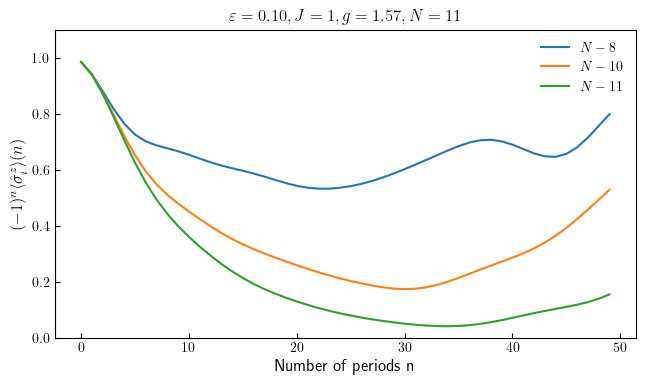

In [23]:
from ssl import Options
from scipy.special import jn_zeros
from itertools import combinations
import numpy as np
from qutip import *
from scipy import signal
import traceback
import tqdm
from multiprocessing import Pool
from scipy.linalg import expm
import matplotlib.pyplot as plt

plt.rcParams.update({"figure.figsize": (7.5,4),"text.usetex": True,"font.family": "sans-serif", "font.size": 12,"font.sans-serif": ["cursive"]})

def pbc_hamiltonian(args):
    N  =  args['N']
    er = args['er']
    J = args['J']
    #beta = args['beta']
    g = args['g']
    h = args['h']
    sx,sy,sz = sigmax(), sigmay(), sigmaz()
    empt = qzero(2**N) + 1j * qzero(2**N)    
    H1, H2, H3 = empt,  empt, empt
        
    for i in range(N-1):
        id = qeye(2**i)    
        dim11 = N-2-i
        id1 = qeye(2**dim11)
        H1 = H1 + Qobj(tensor(id, tensor(sz, tensor(sz, id1))).full())        
    H1 = H1 + Qobj(tensor(sz, tensor(qeye(2**(N-2)), sz)).full())
        
    for i in range(N):
        id = qeye(2**i)    
        dim11 = N-1-i
        id1 = qeye(2**dim11)
        H2 = H2 + Qobj(tensor(id,tensor(sx,id1)).full()) 
                
    for i in range(N):
        id = qeye(2**i)    
        dim11 = N-1-i
        id1 = qeye(2**dim11)
        H3 = H3 + Qobj(tensor(id,tensor(sz,id1)).full())

    H01 = - J * H1
    H11 = - Qobj(H2.full() * er + h * H3.full())
    H02 = - g * H2

    return H01, H11, H02, H3

def strobs_exps(args):
    N = args['N']
    nn = args['nn']    
    
    H01, H11, H02, H3 = pbc_hamiltonian(args)
    V = (H01/ N).full()
    k_eh = H11.full()
    k_pi = H02.full()

    expValues = []
    # Use scipy.linalg.expm for proper matrix exponentiation to ensure unitarity

    U = expm(-1j * k_pi) @ expm(-1j * k_eh) @ expm(-1j * V)
    psi = basis(2**N, 0).full()

    identity_check = U.conj().T @ U
    print("Is U unitary?", np.allclose(identity_check, np.eye(identity_check.shape[0])))

    for i in range(nn):
        psi = U @ psi  # apply unitary
        expValue = np.real(np.vdot(psi, -(H3/N).full() @ psi))  # expectation value
        expValues.append(expValue)
        
    return expValues

Ns = [8, 10, 11]

#Time period upto which stroboscopic evolution is computed
nn = 50
J = 1
g = np.pi/2
er = 0.1
h  = 0.8
    
params = [{'er':er, 'N':N,'J':J, 'g':g, 'maxT':nn, 'h':h, 'nn':nn} for N in Ns]
nprocs = len(Ns)
p = Pool(processes = nprocs) 
opts = Options(nsteps=1e10, num_cpus=1, openmp_threads=1)

data_strob = np.array(p.map(strobs_exps, params))
    
order_param = np.array([(-1)**(i) for i in np.arange(nn)])
for idx, N in enumerate(Ns):
    plt.plot(np.arange(nn), order_param * data_strob[idx], label=fr"$N-{N}$")
    #plt.plot(np.arange(nn), expValues)

#plt.ylim(-1.1,1.1)
#for i in np.arange(0, nn, 2):
#    plt.axvline(x = i, color = 'magenta', alpha = 0.4, ls ='--')

plt.xlabel(r'Number of periods n')
plt.ylabel(r'$(-1)^n\langle \hat{\sigma}^z_i \rangle(n)$')
plt.title(fr"$\varepsilon={er:1.2f}, J={J}, g={g:2.2f}, N={N}$", fontsize = 12)
plt.tick_params(axis='both', which='both', labelsize=10)
plt.tick_params(which='both', direction='in')
plt.ylim(0, 1.1)
plt.legend(frameon = False, fontsize = 10)
plt.show()

Is U unitary? True
Is U unitary? True


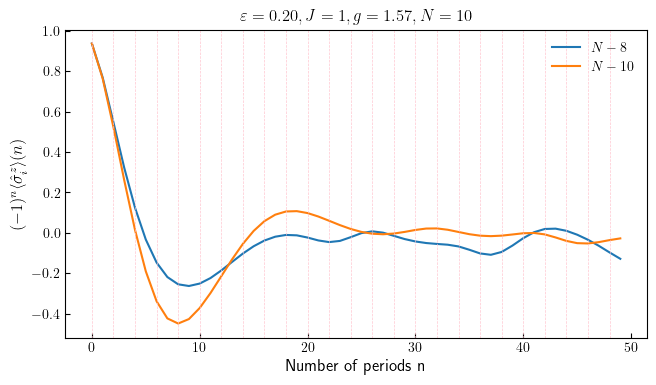

In [30]:
from ssl import Options
from scipy.special import jn_zeros
from itertools import combinations
import numpy as np
from qutip import *
from scipy import signal
import traceback
import tqdm
from multiprocessing import Pool
from scipy.linalg import expm
import matplotlib.pyplot as plt

def pbc_hamiltonian(args):
    N  =  args['N']
    er = args['er']
    J = args['J']
    #beta = args['beta']
    g = args['g']
    h = args['h']
    sx,sy,sz = sigmax(), sigmay(), sigmaz()
    empt = qzero(2**N) + 1j * qzero(2**N)    
    H1, H2, H3 = empt,  empt, empt
        
    for i in range(N-1):
        id = qeye(2**i)    
        dim11 = N-2-i
        id1 = qeye(2**dim11)
        H1 = H1 + Qobj(tensor(id, tensor(sz, tensor(sz, id1))).full())        
    H1 = H1 + Qobj(tensor(sz, tensor(qeye(2**(N-2)), sz)).full())
        
    for i in range(N):
        id = qeye(2**i)    
        dim11 = N-1-i
        id1 = qeye(2**dim11)
        H2 = H2 + Qobj(tensor(id,tensor(sx,id1)).full()) 
                
    for i in range(N):
        id = qeye(2**i)    
        dim11 = N-1-i
        id1 = qeye(2**dim11)
        H3 = H3 + Qobj(tensor(id,tensor(sz,id1)).full())

    H01 = - J * H1
    H11 = - Qobj(H2.full() * er + h * H3.full())
    H02 = - g * H2

    return H01, H11, H02, H3

def strobs_exps(args):
    N = args['N']
    nn = args['nn']    
    
    H01, H11, H02, H3 = pbc_hamiltonian(args)
    V = (H01/ N).full()
    k_eh = H11.full()
    k_pi = H02.full()

    expValues = []
    # Use scipy.linalg.expm for proper matrix exponentiation to ensure unitarity

    U = expm(-1j * k_pi) @ expm(-1j * k_eh) @ expm(-1j * V)
    psi = basis(2**N, 0).full()

    identity_check = U.conj().T @ U
    print("Is U unitary?", np.allclose(identity_check, np.eye(identity_check.shape[0])))

    for i in range(nn):
        psi = U @ psi  # apply unitary
        expValue = np.real(np.vdot(psi, -(H3/N).full() @ psi))  # expectation value
        expValues.append(expValue)
        
    return expValues

Ns = [8, 10]
nn = 50  # Time period upto which stroboscopic evolution is computed
J = 1
g = np.pi/2
er = 0.2
h  = 0.8

params = [{'er':er, 'N':N,'J':J, 'g':g, 'maxT':nn, 'h':h, 'nn':nn} for N in Ns]
nprocs = len(Ns)
p = Pool(processes = nprocs) 
opts = Options(nsteps=1e10, num_cpus=1, openmp_threads=1)

data_strob = np.array(p.map(strobs_exps, params))
    
order_param = np.array([(-1)**(i) for i in np.arange(nn)])
for idx, N in enumerate(Ns):
    plt.plot(np.arange(nn), order_param * data_strob[idx], label=fr"$N-{N}$")
    #plt.plot(np.arange(nn), expValues)

#plt.ylim(-1.1,1.1)
for i in np.arange(0, nn, 2):
    plt.axvline(x = i, color = 'pink', alpha = 0.9, lw = 0.5, ls ='--')


plt.xlabel('Number of periods n')
plt.ylabel(r'$(-1)^n\langle \hat{\sigma}^z_i \rangle(n)$')
plt.title(fr"$\varepsilon={er:1.2f}, J={J}, g={g:2.2f}, N={N}$", fontsize = 12)
plt.tick_params(axis='both', which='both', labelsize=10)
plt.tick_params(which='both', direction='in')

#plt.ylim(0.95, 1)
plt.legend(frameon = False, fontsize = 10)
plt.show()

Is U unitary? True
Is U unitary? True
Is U unitary? True
Is U unitary? True
Is U unitary? True


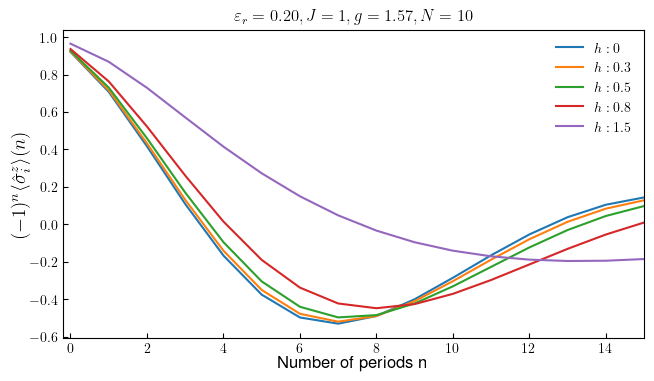

In [41]:
from ssl import Options
from scipy.special import jn_zeros
from itertools import combinations
import numpy as np
from qutip import *
from scipy import signal
import traceback
import tqdm
from multiprocessing import Pool
from scipy.linalg import expm
import matplotlib.pyplot as plt

def pbc_hamiltonian(args):
    N  =  args['N']
    er = args['er']
    J = args['J']
    #beta = args['beta']
    g = args['g']
    h = args['h']
    sx,sy,sz = sigmax(), sigmay(), sigmaz()
    empt = qzero(2**N) + 1j * qzero(2**N)    
    H1, H2, H3 = empt,  empt, empt
        
    for i in range(N-1):
        id = qeye(2**i)    
        dim11 = N-2-i
        id1 = qeye(2**dim11)
        H1 = H1 + Qobj(tensor(id, tensor(sz, tensor(sz, id1))).full())        
    H1 = H1 + Qobj(tensor(sz, tensor(qeye(2**(N-2)), sz)).full())
        
    for i in range(N):
        id = qeye(2**i)    
        dim11 = N-1-i
        id1 = qeye(2**dim11)
        H2 = H2 + Qobj(tensor(id,tensor(sx,id1)).full()) 
                
    for i in range(N):
        id = qeye(2**i)    
        dim11 = N-1-i
        id1 = qeye(2**dim11)
        H3 = H3 + Qobj(tensor(id,tensor(sz,id1)).full())

    H01 = - J * H1
    H11 = - Qobj(H2.full() * er + h * H3.full())
    H02 = - g * H2

    return H01, H11, H02, H3

N = 10
nn = 50  # Time period upto which stroboscopic evolution is computed
J = 1
g = np.pi/2
er = 0.2
hs  = [0, 0.3, 0.5, 0.8, 1.5]

def strobs_exps(args):
    N = args['N']
    nn = args['nn']    
    
    H01, H11, H02, H3 = pbc_hamiltonian(args)
    V = (H01/ N).full()
    k_eh = H11.full()
    k_pi = H02.full()

    expValues = []
    # Use scipy.linalg.expm for proper matrix exponentiation to ensure unitarity

    U = expm(-1j * k_pi) @ expm(-1j * k_eh) @ expm(-1j * V)
    psi = basis(2**N, 0).full()

    identity_check = U.conj().T @ U
    print("Is U unitary?", np.allclose(identity_check, np.eye(identity_check.shape[0])))

    for i in range(nn):
        psi = U @ psi  # apply unitary
        expValue = np.real(np.vdot(psi, -(H3/N).full() @ psi))  # expectation value
        expValues.append(expValue)
        
    return expValues
    

params = [{'er':er, 'N':N,'J':J, 'g':g, 'maxT':nn, 'h':h, 'nn':nn} for h in hs]

nprocs = len(hs)
p = Pool(processes = nprocs) 
opts = Options(nsteps=1e10, num_cpus=1, openmp_threads=1)

data_strob = np.array(p.map(strobs_exps, params))
    
order_param = np.array([(-1)**(i) for i in np.arange(nn)])
for idx, h in enumerate(hs):
    plt.plot(np.arange(nn), order_param * data_strob[idx], label=fr"$h:{h}$")
    #plt.plot(np.arange(nn), expValues)

#plt.ylim(-1.1,1.1)
#for i in np.arange(0, nn, 2):
#    plt.axvline(x = i, color = 'blue', alpha = 0.3,ls ='--')


plt.xlabel('Number of periods n', fontsize = 12, labelpad=0)
plt.ylabel(r'$(-1)^n\langle \hat{\sigma}^z_i \rangle(n)$', fontsize = 14, labelpad=0)
plt.title(fr"$\varepsilon_r={er:1.2f}, J={J}, g={g:2.2f}, N={N}$", fontsize = 12)
plt.tick_params(axis='both', which='both', labelsize=10)
plt.tick_params(which='both', direction='in')
plt.xlim(-0.2, 15)
#plt.ylim(-0.1, 1.1)

plt.legend(frameon =False, fontsize = 10)
plt.show()